## CMSC 35300 Final Project: Lasso Models
Shweta Kamath <br>
Nivedita Vatsa <br>
Carolyn Vilter

#### Setup

Source: https://gist.github.com/agramfort/ac52a57dc6551138e89b

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import compress

In [2]:
import time
from math import sqrt
from scipy import linalg # used to calculate norm

In [3]:
# Import data
df = pd.read_csv("data/all_data_standardized.csv")

In [4]:
# Separate out Xs
X = df.loc[:, ~df.columns.isin(["child_id", "mother_id", "treat_alike_scale", "treat_alike_binary"])]
X = X.to_numpy()

# add columns of 1s
A = np.hstack((np.ones((len(X), 1)), X))
A_names = df.columns[(~df.columns.isin(["child_id", "mother_id", "treat_alike_scale", "treat_alike_binary"]))]

# Separate out two prospective ys
y_scale = df.loc[:, df.columns == "treat_alike_scale"]
y_scale = y_scale.to_numpy()

# y_binary = df.loc[:, df.columns == "treat_alike_binary"]
# y_binary = y_binary.to_numpy()

In [5]:
df

,child_id,mother_id,treat_alike_scale,treat_alike_binary,year_at_y,gap_at_y,self_worth,yob_child,father_present,religion_freq,...,highest_expected_grade_GET MORE THAN 4 YEARS OF COLLEGE,highest_expected_grade_SOMETHING ELSE,mother_race_BLACK,"mother_race_NON-BLACK, NON-HISPANIC",mother_relig_raised_protestant,mother_relig_raised_catholic,mother_relig_raised_other,mother_relig_current_protestant,mother_relig_current_catholic,mother_relig_current_other
0,301,3,2,1,0.0,0.5,0.555556,0.045455,1.000000,0.2,...,0,0,0,1,0,1,0,0,1,0
1,302,3,1,1,0.1,0.5,1.000000,0.136364,1.000000,0.5,...,0,0,0,1,0,1,0,0,1,0
2,303,3,1,1,0.3,1.0,0.888889,0.272727,1.000000,0.8,...,0,0,0,1,0,1,0,0,0,1
3,803,8,1,1,0.1,1.0,0.611111,0.090909,0.363636,0.2,...,0,0,0,1,0,0,1,1,0,0
4,1601,16,1,1,0.5,1.0,0.666667,0.454545,1.000000,0.6,...,0,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5156,1255801,12558,2,1,0.4,0.5,1.000000,0.409091,0.000000,1.0,...,0,0,1,0,0,0,1,0,0,1
5157,1256602,12566,2,1,0.2,0.5,0.888889,0.227273,1.000000,1.0,...,0,0,1,0,1,0,0,1,0,0
5158,1256603,12566,1,1,0.4,1.0,0.888889,0.363636,0.888889,1.0,...,1,0,1,0,1,0,0,1,0,0
5159,1256604,12566,1,1,0.5,0.0,0.944444,0.545455,0.714286,1.0,...,1,0,1,0,1,0,0,1,0,0


### Lasso Regression
Predict repeatedly using cross validation; plot test error.

In [6]:
def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0.)


def ista(A, b, l, maxit):
    x = np.zeros((A.shape[1], 1))
    # x = np.zeros(A.shape[1])
    pobj = []
    L = linalg.norm(A) ** 2  # Lipschitz constant
    time0 = time.time()
    for _ in range(maxit):
        x = soft_thresh(x + np.dot(A.T, b - A.dot(x)) / L, l / L)
        this_pobj = 0.5 * linalg.norm(A.dot(x) - b) ** 2 + l * linalg.norm(x, 1)
        pobj.append((time.time() - time0, this_pobj))

    times, pobj = map(np.array, zip(*pobj))
    return x, pobj, times


def fista(A, b, l, maxit):
    x = np.zeros((A.shape[1], 1))
    # x = np.zeros(A.shape[1])
    pobj = []
    t = 1
    z = x.copy()
    L = linalg.norm(A) ** 2
    time0 = time.time()
    for _ in range(maxit):
        xold = x.copy()
        z = z + A.T.dot(b - A.dot(z)) / L
        x = soft_thresh(z, l / L)
        t0 = t
        t = (1. + sqrt(1. + 4. * t ** 2)) / 2.
        z = x + ((t0 - 1.) / t) * (x - xold)
        this_pobj = 0.5 * linalg.norm(A.dot(x) - b) ** 2 + l * linalg.norm(x, 1)
        pobj.append((time.time() - time0, this_pobj))

    times, pobj = map(np.array, zip(*pobj))
    return x, pobj, times

def predict_scale_labels(y_scale_pred):
    '''
    Assign label 1 through 4
    
    arg:
    - y_scale_pred: vector of predicted y values
    
    Returns: vector of predicted y labels (1 through 4)
    '''
    # generate nx4 matrix where each column is 1,2,3,4
    m = y_scale_pred.shape[0]
    y_scale_pred = y_scale_pred.reshape(m, 1)
    mat = np.tile(np.arange(4)+1, (m,1))
    
    # find lowest absolute distance
    return np.argmin(abs(mat - y_scale_pred), axis=1).reshape(m, 1)


def get_error_rate(y_label, y_label_pred):
    '''
    '''
    return 100*np.sum(np.round(y_label) != np.round(y_label_pred))/len(y_label_pred)


def estimate_solution(At, Ah, b, l, maxit, algo):
    '''
    args:
    - At: training data
    - Ah: holdout data
    - b: response variable
    - l: regularization parameter
    - maxit: maximum number of iterations
    - algo: ISTA or FISTA
    '''
    if algo=="ista":
        x_,  pobj_,  times_ =  ista(At, b, l, maxit)
        
    elif algo=="fista":
        x_,  pobj_,  times_ =  fista(At, b, l, maxit)
        
    else:
        print("\n error in algo specification!")

    y_pred = Ah.dot(x_)
    y_scale_pred  = predict_scale_labels(y_pred)
    
    return x_, y_pred, y_scale_pred


def report_results(x_, y_scale, y_scale_pred, A_names, algo):
    '''
    '''
    if algo=="ista":
        print("---------------ISTA---------------")
        
    elif algo=="fista":
        print("---------------FISTA---------------")
        
    else:
        print("error in algo specification! \n")
    
    print("---predicted labels---")
    print(np.unique(y_scale_pred, return_counts=True),"\n")
    
    print("---error rate---")
    error_rate = get_error_rate(y_scale, y_scale_pred)
    print(error_rate)
    
    # values of non-zero parameters
    filt_zero = np.round(x_[1:], 4)==0.0

#     print("\n----------------non-zero coefficients----------------")
#     for feat, coef in zip(list(compress(A_names, ~filt_zero)),
#                           np.round(x_[1:], 3)[~filt_zero]):
#         print(f"{feat}: {coef}")
        
#     print("\n----------------zero coefficients----------------")
#     for feat, coef in zip(list(compress(A_names, filt_zero)),
#                           np.round(x_[1:], 3)[filt_zero]):
#         print(f"{feat}: {coef}")

    print("---number of non-zero coefficients---")
    sparsity = sum(~filt_zero)
    print(sparsity)
    return error_rate, sparsity, filt_zero

In [7]:
b = y_scale
maxit = 1000
lamdas = np.linspace(0.1, 5.1, 50)

In [8]:
er_list = []
sparsity_list = []
s_bool_list = []
for l in lamdas:
    for a in ["ista"]:
        x_, y_pred_, y_scale_pred_ = estimate_solution(A, A, b, l, maxit, a)
        print("=============================LAMBDA=============================\n", l)
        er, s, s_bool = report_results(x_, y_scale, y_scale_pred_, A_names, a)
        er_list.append(er)
        sparsity_list.append(s)
        s_bool_list.append(~s_bool)

=============================LAMBDA=============================
 0.1
---------------ISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3849, 1312], dtype=int64)) 

---error rate---
86.02983917845378
---number of non-zero coefficients---
[43]
=============================LAMBDA=============================
 0.20204081632653062
---------------ISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3852, 1309], dtype=int64)) 

---error rate---
86.0685913582639
---number of non-zero coefficients---
[43]
=============================LAMBDA=============================
 0.3040816326530612
---------------ISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3855, 1306], dtype=int64)) 

---error rate---
86.12671962797907
---number of non-zero coefficients---
[43]
=============================LAMBDA=============================
 0.4061224489795918
---------------ISTA---------------
---predicted labels---
(array([0, 1],

=============================LAMBDA=============================
 3.059183673469388
---------------ISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3914, 1247], dtype=int64)) 

---error rate---
86.63049796551056
---number of non-zero coefficients---
[41]
=============================LAMBDA=============================
 3.1612244897959187
---------------ISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3916, 1245], dtype=int64)) 

---error rate---
86.64987405541562
---number of non-zero coefficients---
[41]
=============================LAMBDA=============================
 3.2632653061224492
---------------ISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3921, 1240], dtype=int64)) 

---error rate---
86.64987405541562
---number of non-zero coefficients---
[41]
=============================LAMBDA=============================
 3.3653061224489798
---------------ISTA---------------
---predicted labels---


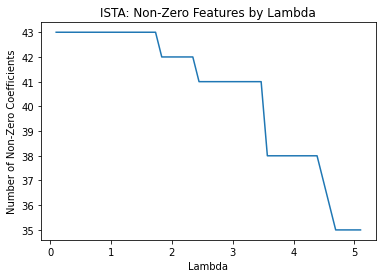

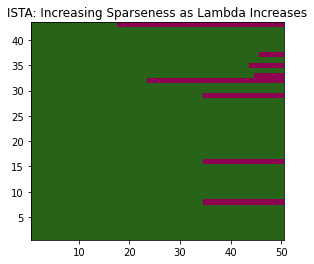

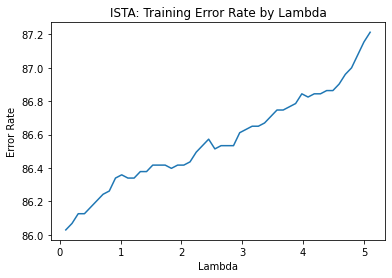

In [9]:
# SPARISTY (COUNT)
plt.plot(lamdas, sparsity_list)
plt.xlabel("Lambda")
plt.ylabel("Number of Non-Zero Coefficients")
plt.title("ISTA: Non-Zero Features by Lambda")
plt.show()

# SPARSITY
data = np.hstack(s_bool_list)
rows, cols = data.shape

plt.imshow(data, interpolation='nearest', 
                 extent=[0.5, 0.5+cols, 0.5, 0.5+rows],
                 cmap='PiYG')
plt.title("ISTA: Increasing Sparseness as Lambda Increases")
plt.show()

# ERROR RATE
plt.plot(lamdas, er_list)
plt.xlabel("Lambda")
plt.ylabel("Error Rate")
plt.title("ISTA: Training Error Rate by Lambda")
plt.show()

In [10]:
er_list = []
sparsity_list = []
s_bool_list = []
for l in lamdas:
    for a in ["fista"]:
        x_, y_pred_, y_scale_pred_ = estimate_solution(A, A, b, l, maxit, a)
        print("=============================LAMBDA=============================\n", l)
        er, s, s_bool = report_results(x_, y_scale, y_scale_pred_, A_names, a)
        er_list.append(er)
        sparsity_list.append(s)
        s_bool_list.append(~s_bool)

=============================LAMBDA=============================
 0.1
---------------FISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3814, 1347], dtype=int64)) 

---error rate---
85.83607827940321
---number of non-zero coefficients---
[43]
=============================LAMBDA=============================
 0.20204081632653062
---------------FISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3819, 1342], dtype=int64)) 

---error rate---
85.91358263902345
---number of non-zero coefficients---
[41]
=============================LAMBDA=============================
 0.3040816326530612
---------------FISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3821, 1340], dtype=int64)) 

---error rate---
85.99108699864368
---number of non-zero coefficients---
[41]
=============================LAMBDA=============================
 0.4061224489795918
---------------FISTA---------------
---predicted labels---
(array([0

=============================LAMBDA=============================
 3.059183673469388
---------------FISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3857, 1304], dtype=int64)) 

---error rate---
86.57236969579539
---number of non-zero coefficients---
[28]
=============================LAMBDA=============================
 3.1612244897959187
---------------FISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3858, 1303], dtype=int64)) 

---error rate---
86.57236969579539
---number of non-zero coefficients---
[26]
=============================LAMBDA=============================
 3.2632653061224492
---------------FISTA---------------
---predicted labels---
(array([0, 1], dtype=int64), array([3861, 1300], dtype=int64)) 

---error rate---
86.57236969579539
---number of non-zero coefficients---
[26]
=============================LAMBDA=============================
 3.3653061224489798
---------------FISTA---------------
---predicted labels

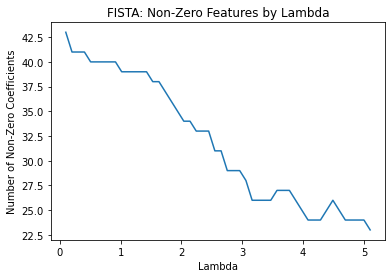

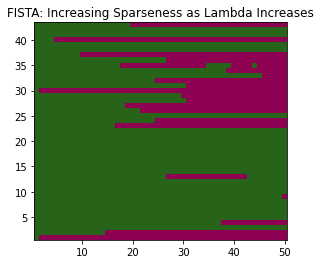

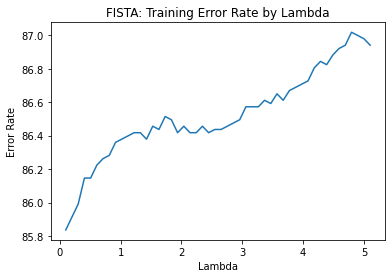

In [11]:
# SPARISTY (COUNT)
plt.plot(lamdas, sparsity_list)
plt.xlabel("Lambda")
plt.ylabel("Number of Non-Zero Coefficients")
plt.title("FISTA: Non-Zero Features by Lambda")
plt.show()

# SPARSITY
data = np.hstack(s_bool_list)
rows, cols = data.shape

plt.imshow(data, interpolation='nearest', 
                 extent=[0.5, 0.5+cols, 0.5, 0.5+rows],
                 cmap='PiYG')
plt.title("FISTA: Increasing Sparseness as Lambda Increases")
plt.show()

# ERROR RATE
plt.plot(lamdas, er_list)
plt.xlabel("Lambda")
plt.ylabel("Error Rate")
plt.title("FISTA: Training Error Rate by Lambda")
plt.show()

## Cross-Validation

In [12]:
num_iter = 100
n = A.shape[0]
maxit = 1000

# Chosen number of sets to divide dataset into
n_sets = 10
# Final index of the training set (9 of 10 subsets)
t_index = n//n_sets*(n_sets-1)

er_list_ista = []
for l in lamdas:
    er_list_lam = []
    for i in range(num_iter):
        # (Re)assign training and hold-out indices
        r = np.random.permutation(n)
        it = r[:t_index]
        ih = r[t_index:]

        # Training data
        At = A[it, :]
        yt_scale = y_scale[it]

        # Holdout
        Ah = A[ih, :]
        yh_scale = y_scale[ih]

        # estimate lasso
        x_,  pobj_,  times_ =  ista(At, yt_scale, l, maxit) # ISTA
        yh_pred = Ah.dot(x_) # get predictions
        yh_scale_pred  = predict_scale_labels(yh_pred) # get predicted labels
        er = get_error_rate(yh_scale, yh_scale_pred) # get error rate
        er_list_lam.append(er)
    er_list_ista.append(np.mean(er_list_lam))
    

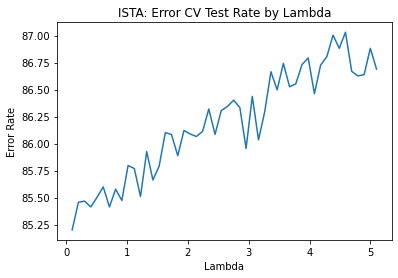

In [13]:
# ERROR RATE
plt.plot(lamdas, er_list_ista)
plt.xlabel("Lambda")
plt.ylabel("Error Rate")
plt.title("ISTA: Error CV Test Rate by Lambda")
plt.show()

In [14]:
# lambda with lowest CV test error rate
best_lamda_ista = lamdas[np.argmin(er_list_ista)]
print(best_lamda_ista)

0.1


In [15]:
num_iter = 100
n = A.shape[0]
maxit = 1000

# Chosen number of sets to divide dataset into
n_sets = 10
# Final index of the training set (9 of 10 subsets)
t_index = n//n_sets*(n_sets-1)

er_list_fista = []
for l in lamdas:
    er_list_lam = []
    for i in range(num_iter):
        # (Re)assign training and hold-out indices
        r = np.random.permutation(n)
        it = r[:t_index]
        ih = r[t_index:]

        # Training data
        At = A[it, :]
        yt_scale = y_scale[it]

        # Holdout
        Ah = A[ih, :]
        yh_scale = y_scale[ih]

        # estimate lasso
        x_,  pobj_,  times_ =  fista(At, yt_scale, l, maxit) # FISTA
        yh_pred = Ah.dot(x_) # get predictions
        yh_scale_pred  = predict_scale_labels(yh_pred) # get predicted labels
        er = get_error_rate(yh_scale, yh_scale_pred) # get error rate
        er_list_lam.append(er)
    er_list_fista.append(np.mean(er_list_lam))
    

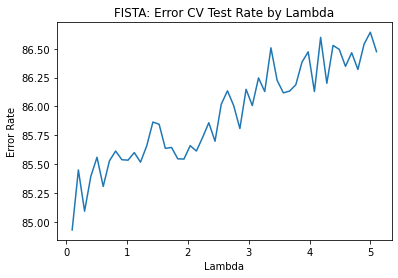

In [16]:
# ERROR RATE
plt.plot(lamdas, er_list_fista)
plt.xlabel("Lambda")
plt.ylabel("Error Rate")
plt.title("FISTA: Error CV Test Rate by Lambda")
plt.show()

In [17]:
# lambda with lowest CV test error rate
best_lamda_fista = lamdas[np.argmin(er_list_fista)]
print(best_lamda_fista)

0.1


## Best Model

In [18]:
x_ista,  pobj_ista,  times_ista =  fista(A, y_scale, best_lamda_ista, maxit)

y_pred = A.dot(x_ista) # get predictions
y_scale_pred  = predict_scale_labels(y_pred) # get predicted labels
er = get_error_rate(y_scale, y_scale_pred) # get error rate
print(f'Error Rate: {er}')

filt_zero = np.round(x_ista[1:], 3)==0.0
print("\n----------------non-zero coefficients----------------")
for feat, coef in zip(list(compress(A_names, ~filt_zero)),
                      np.round(x_ista[1:], 3)[~filt_zero]):
    print(f"{feat}: {coef}")

print("\n----------------zero coefficients----------------")
for feat, coef in zip(list(compress(A_names, filt_zero)),
                      np.round(x_ista[1:], 3)[filt_zero]):
    print(f"{feat}: {coef}")

Error Rate: 85.83607827940321

----------------non-zero coefficients----------------
gap_at_y: 0.029
self_worth: -0.195
yob_child: 0.014
father_present: 0.015
religion_freq: 0.075
hgc: -0.073
woman_place_in_the_home_birth: 0.064
woman_place_in_the_home_y: -0.046
wife_w_fam_no_tm_o_emp_birth: 0.094
wife_w_fam_no_tm_o_emp_y: -0.121
wrkng_sp_feel_more_useful_birth: -0.075
wrkng_sp_feel_more_useful_y: 0.089
emp_wife_lead_juv_delin_y: -0.028
infl_neces_emp_2_parents_birth: -0.071
infl_neces_emp_2_parents_y: -0.018
trade_husband_wife_roles_birth: 0.053
trade_husband_wife_roles_y: -0.171
men_should_share_housework_birth: 0.138
men_should_share_housework_y: -0.092
women_happier_trade_roles_birth: 0.114
women_happier_trade_roles_y: 0.14
hours_works_at_y: 0.093
num_jobs_ever_at_y: -0.143
avg_poverty_status: 0.071
avg_fam_inc: -0.27
race_child_BLACK: -0.024
race_child_NON-BLACK, NON-HISPANIC: -0.047
sex_child_FEMALE: -0.065
highest_expected_grade_GRADUATE FROM HIGH SCHOOL: -0.199
highest_expected

In [19]:
x_fista,  pobj_fista,  times_fista =  fista(A, y_scale, best_lamda_fista, maxit)

y_pred = A.dot(x_fista) # get predictions
y_scale_pred  = predict_scale_labels(y_pred) # get predicted labels
er = get_error_rate(y_scale, y_scale_pred) # get error rate
print(f'Error Rate: {er}')

filt_zero = np.round(x_fista[1:], 3)==0.0
print("\n----------------non-zero coefficients----------------")
for feat, coef in zip(list(compress(A_names, ~filt_zero)),
                      np.round(x_fista[1:], 3)[~filt_zero]):
    print(f"{feat}: {coef}")

print("\n----------------zero coefficients----------------")
for feat, coef in zip(list(compress(A_names, filt_zero)),
                      np.round(x_fista[1:], 3)[filt_zero]):
    print(f"{feat}: {coef}")

Error Rate: 85.83607827940321

----------------non-zero coefficients----------------
gap_at_y: 0.029
self_worth: -0.195
yob_child: 0.014
father_present: 0.015
religion_freq: 0.075
hgc: -0.073
woman_place_in_the_home_birth: 0.064
woman_place_in_the_home_y: -0.046
wife_w_fam_no_tm_o_emp_birth: 0.094
wife_w_fam_no_tm_o_emp_y: -0.121
wrkng_sp_feel_more_useful_birth: -0.075
wrkng_sp_feel_more_useful_y: 0.089
emp_wife_lead_juv_delin_y: -0.028
infl_neces_emp_2_parents_birth: -0.071
infl_neces_emp_2_parents_y: -0.018
trade_husband_wife_roles_birth: 0.053
trade_husband_wife_roles_y: -0.171
men_should_share_housework_birth: 0.138
men_should_share_housework_y: -0.092
women_happier_trade_roles_birth: 0.114
women_happier_trade_roles_y: 0.14
hours_works_at_y: 0.093
num_jobs_ever_at_y: -0.143
avg_poverty_status: 0.071
avg_fam_inc: -0.27
race_child_BLACK: -0.024
race_child_NON-BLACK, NON-HISPANIC: -0.047
sex_child_FEMALE: -0.065
highest_expected_grade_GRADUATE FROM HIGH SCHOOL: -0.199
highest_expected

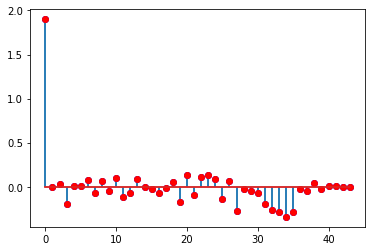

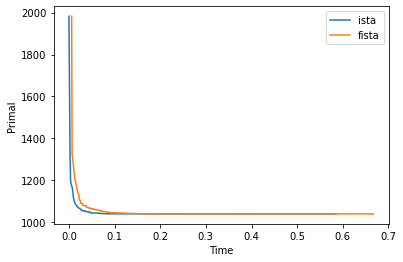

In [20]:
plt.close('all')

plt.figure()
# plt.stem(x0, markerfmt='go')
plt.stem(x_ista, markerfmt='bo')
plt.stem(x_fista, markerfmt='ro')

plt.figure()
plt.plot(times_ista, pobj_ista, label='ista')
plt.plot(times_fista, pobj_fista, label='fista')
plt.xlabel('Time')
plt.ylabel('Primal')
plt.legend()
plt.show()

-----------

## Attempt 1

In [21]:
# # setup
# rng = np.random.RandomState(42)
# m, n = A.shape

# x0 = rng.rand(n)
# x0[x0 < 0.9] = 0

# b = np.dot(A, x0)
# l = 0.01  # regularization parameter

# maxit = 1000

In [22]:
# x_ista,  y_pred_ista,  y_scale_pred_ista  = estimate_solution(A, b, l, maxit, "ista")
# x_fista, y_pred_fista, y_scale_pred_fista = estimate_solution(A, b, l, maxit, "fista")

In [23]:
# x_ista,  pobj_ista,  times_ista  =  ista(A, b, l, maxit) # ista
# y_pred_ista = A.dot(x_ista)
# y_scale_pred_ista  = predict_scale_labels(y_pred_ista)

# x_fista, pobj_fista, times_fista = fista(A, b, l, maxit) # fista
# y_pred_fista = A.dot(x_fista)
# y_scale_pred_fista = predict_scale_labels(y_pred_fista)

In [24]:
# print("=============ISTA=============")

# print("---predicted values---")
# print(y_pred_ista,"\n")

# print("---predicted labels---")
# print(np.unique(y_scale_pred_ista, return_counts=True),"\n")

# # errors
# print("Error rate:", get_error_rate(y_scale, y_scale_pred_ista))

# # values of non-zero parameters
# filt_ista_zero = np.round(x_ista[1:], 4)==0.0

# print("----------------non-zero coefficients----------------")
# for feat, coef in zip(list(compress(A_names, ~filt_ista_zero)),
#                       np.round(x_ista[1:], 3)[~filt_ista_zero]):
#     print(f"{feat}: {coef}")
# print("----------------zero coefficients----------------")
# for feat, coef in zip(list(compress(A_names, filt_ista_zero)),
#                       np.round(x_ista[1:], 3)[filt_ista_zero]):
#     print(f"{feat}: {coef}")

In [25]:
# print("=============FISTA=============")

# print("---predicted values---")
# print(y_pred_fista)

# print("---predicted labels---")
# print(np.unique(y_scale_pred_fista, return_counts=True),"\n")

# # errors
# print("Error rate:", get_error_rate(y_scale, y_scale_pred_fista))

# # values of non-zero parameters
# filt_fista_zero = np.round(x_fista[1:], 4)==0.0

# print("----------------non-zero coefficients----------------")
# for feat, coef in zip(list(compress(A_names, ~filt_fista_zero)),
#                       np.round(x_fista[1:], 3)[~filt_fista_zero]):
#     print(f"{feat}: {coef}")
# print("----------------zero coefficients----------------")
# for feat, coef in zip(list(compress(A_names, filt_fista_zero)),
#                       np.round(x_fista[1:], 3)[filt_fista_zero]):
#     print(f"{feat}: {coef}")

In [26]:
# import matplotlib.pyplot as plt
# plt.close('all')

# plt.figure()
# plt.stem(x0, markerfmt='go')
# plt.stem(x_ista, markerfmt='bo')
# plt.stem(x_fista, markerfmt='ro')

# plt.figure()
# plt.plot(times_ista, pobj_ista, label='ista')
# plt.plot(times_fista, pobj_fista, label='fista')
# plt.xlabel('Time')
# plt.ylabel('Primal')
# plt.legend()
# plt.show()

## Sklearn

In [27]:
# from sklearn.linear_model import Lasso

In [28]:
# er_sklearn_list = []
# for a in lamdas:
#     lasso_sklearn = Lasso(alpha = a)
#     lasso_sklearn.fit(A, y_scale)

#     # predict the value
#     y_pred_sklearn = lasso_sklearn.predict(A)
#     y_pred_sklearn_labels = predict_scale_labels(y_pred_sklearn)
#     er_sklearn = get_error_rate(y_scale, y_pred_sklearn_labels)
#     er_sklearn_list.append(er_sklearn)
# #     print("===y hat===")
# #     print(y_pred_sklearn)
# #     print("===y hat labels===")
# #     print(y_pred_sklearn_labels)
# #     print("===error rate===")
# #     print(get_error_rate(y_scale, y_pred_sklearn_labels))

In [29]:
# plt.plot(lamdas, er_sklearn_list)
# plt.xlabel("Lambda")
# plt.ylabel("Error Rate (Sklearn)")
# plt.show()

In [30]:
# # values of non-zero parameters
# filt_sklearn_zero = np.round(lasso_sklearn.coef_[1:], 4)==0.0

# print("----------------non-zero coefficients----------------")
# for feat, coef in zip(list(compress(A_names, ~filt_sklearn_zero)),
#                       np.round(lasso_sklearn.coef_[1:], 3)[~filt_sklearn_zero]):
#     print(f"{feat}: {coef}")
# print("----------------zero coefficients----------------")
# for feat, coef in zip(list(compress(A_names, filt_sklearn_zero)),
#                       np.round(lasso_sklearn.coef_[1:], 3)[filt_sklearn_zero]):
#     print(f"{feat}: {coef}")